# Models

## Initialization and Loading Data


### Init

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/HKU/STAT3612/Project/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/HKU/STAT3612/Project


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

seed = 4250

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve

### Useful functions

In [ ]:
def evaluate(rf, train, valid, test, train_y, valid_y, return_pred=False, version=1, return_auc=False, plot_auc=False):
    if version == 2:
        rf_train_y = rf.predict(train)
        rf_valid_y = rf.predict(valid)
        pred = rf.predict(test)
        acr_train = rf.score(train, train_y)
        acr_valid = rf.score(valid, valid_y)
        print(f"Train Accuracy: {acr_train:.4f}; Validation Accuracy: {acr_valid:.4f}; Test: {np.sum(pred):>4d}")
        cm = confusion_matrix(train_y, rf_train_y)
        tn, fp, fn, tp = cm.ravel()
        print(f"Train AUROC: {roc_auc_score(train_y, rf_train_y):.4f}; FP: {fp:>4d}; FN: {fn:>4d}")
        cm = confusion_matrix(valid_y, rf_valid_y)
        tn, fp, fn, tp = cm.ravel()
        print(f"Valid AUROC: {roc_auc_score(valid_y, rf_valid_y):.4f}; FP: {fp:>4d}; FN: {fn:>4d}")
        print()
    elif version == 3:
        pred_train = rf.predict(train)
        pred_valid = rf.predict(valid)
        pred = rf.predict(test)
        print(f"Train RMSE: {mse(train_y, pred_train, squared=False):.4f}")
        print(f"Valid RMSE: {mse(valid_y, pred_valid, squared=False):.4f}")
    else:
        rf_train_y = rf.predict_proba(train)[:,1]
        rf_valid_y = rf.predict_proba(valid)[:,1]
        pred = rf.predict_proba(test)[:,1]
        acr_train = rf.score(train, train_y)
        acr_valid = rf.score(valid, valid_y)
        print(f"Train Accuracy: {acr_train:.4f}; Validation Accuracy: {acr_valid:.4f}")
        auc_train = roc_auc_score(train_y, rf_train_y)
        auc_valid = roc_auc_score(valid_y, rf_valid_y)
        print(f"Train AUROC: {auc_train:.4f}")
        print(f"Valid AUROC: {auc_valid:.4f}")
        print()
    if plot_auc:
        try:
            fpr1, tpr1, thresholds1 = roc_curve(train_y, rf_train_y)
            fpr2, tpr2, thresholds2 = roc_curve(valid_y, rf_valid_y)
            plt.plot([0,1], 'k--')
            plt.plot(fpr1, tpr1, label= "Train")
            plt.plot(fpr2, tpr2, label= "Valid")
            plt.legend()
            plt.xlabel("FPR")
            plt.ylabel("TPR")
            plt.title('AUROC Curve')
            plt.show()
            # plot_roc_curve(rf, train, train_y)
            # plot_roc_curve(rf, valid, valid_y)
        except:
            pass
    if return_pred and return_auc and version == 1:
        return pred, auc_train, auc_valid
    elif return_pred:
        return pred
    else:
        return

In [ ]:
def std(train, valid, test=None):
    scaler = StandardScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    valid = scaler.transform(valid)
    if test is None:
        return train, valid
    else:
        test = scaler.transform(test)
        return train, valid, test

In [ ]:
def minmax(train, valid, test=None):
    scaler = MinMaxScaler()
    scaler.fit(train)
    train = scaler.transform(train)
    valid = scaler.transform(valid)
    if test is None:
        return train, valid
    else:
        test = scaler.transform(test)
        return train, valid, test

### Prepare X

#### Raw

In [ ]:
train = pd.read_pickle('./data/X_train.pkl')
valid = pd.read_pickle('./data/X_valid.pkl')
test = pd.read_pickle('./data/X_test.pkl')
print(f"Train: {train.shape}\nValid: {valid.shape}")

Train: (16760, 7488)
Valid: (2394, 7488)


#### Finalized

In [ ]:
feature_num = train.shape[1]
mi_importance = np.load(f"./data/MI_importance_{feature_num}.npy")

In [ ]:
num = 600
mi_importance_index = np.argpartition(mi_importance, -num)[-num:]

### Prepare Y

In [ ]:
train_y = pd.read_pickle('./data/Y_train_1.pkl')
valid_y = pd.read_pickle('./data/Y_valid_1.pkl')

train_lbl0 = (train_y.to_numpy() == 0).sum()
train_lbl1 = (train_y.to_numpy() == 1).sum()
valid_lbl0 = (valid_y.to_numpy() == 0).sum()
valid_lbl1 = (valid_y.to_numpy() == 1).sum()

print(f"Train (label = 0): {train_lbl0:>5d}\nTrain (label = 1): {train_lbl1:>5d}")
print(f"Valid (label = 0): {valid_lbl0:>5d}\nValid (label = 1): {valid_lbl1:>5d}")

weight_for_0 = (1 / train_lbl0) * (train_lbl0 + train_lbl1) / 2.0 
weight_for_1 = (1 / train_lbl1) * (train_lbl0 + train_lbl1) / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}
print(class_weight)

Train (label = 0): 15535
Train (label = 1):  1225
Valid (label = 0):  2242
Valid (label = 1):   152
{0: 0.5394271000965563, 1: 6.840816326530613}


### Deal with Imbalanced Dataset: SMOTE


#### Oversampling

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN

In [ ]:
smote = False
if smote:
    train_resampled, train_y_resampled = SMOTE(random_state=seed).fit_resample(train, train_y)
    print(train_resampled.shape)
    train, train_y = train_resampled, train_y_resampled

### Normalization

In [ ]:
minmax = False
if minmax:
    train, valid, test = minmax(train, valid, test)
else:
    train, valid, test = std(train, valid, test)

## PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def pca_result(df, n=1):
    pca = PCA(n_components=n, random_state=seed)
    df_nd = pca.fit_transform(df)
    df_recon = pca.inverse_transform(df_nd).round(0)
    df_recon[df_recon<=0] = 0
    df_recon_err = np.mean(np.sum(np.square(df_recon - df), axis=1))
    cols = [("Component" + str(i+1)) for i in range(pca.components_.shape[0])]
    components = pd.DataFrame(pca.components_.T, columns=cols, index=df.columns)
    explained_var = pca.explained_variance_ratio_.sum()
    result = {
        "pca": pca,
        "pca_components": components,
        "explained_variance": explained_var,
        "data_dimension_reduction": df_nd,
        "data_reconstruction": df_recon,
        "data_reconstruction_error": df_recon_err,
    }
    return result

In [ ]:
# train, valid, test = std(train, valid, test)
# train = pd.DataFrame(train)
# valid = pd.DataFrame(valid)
# test  = pd.DataFrame(test)

# for i in range(50, 150+1, 10):
#     pca = pca_result(train, i)
#     print(i, pca["explained_variance"])

In [ ]:
train, valid, test = std(train, valid, test)
train = pd.DataFrame(train)
valid = pd.DataFrame(valid)
test  = pd.DataFrame(test)

pca = pca_result(train, 350)
print(pca["explained_variance"])

0.804116650722556


In [ ]:
pca_num = 350
pca_train = pca_result(train, pca_num)["data_dimension_reduction"]
pca_valid = pca_result(valid, pca_num)["data_dimension_reduction"]
pca_test  = pca_result(test,  pca_num)["data_dimension_reduction"]

In [ ]:
# train = pca_train
# valid = pca_valid
# test  = pca_test

## SVD

In [ ]:
from sklearn.decomposition import TruncatedSVD 

In [ ]:
# for i in range(1, 11):
#     svd = TruncatedSVD(n_components=i, random_state=seed)
#     svd.fit_transform(train)
#     print(svd.explained_variance_ratio_)

In [ ]:
svd = TruncatedSVD(n_components=350, random_state=seed)
svd.fit_transform(train)
print(sum(svd.explained_variance_ratio_))

0.8036748894428122


In [ ]:
svd_num = 350
svd = TruncatedSVD(n_components=svd_num, random_state=seed)
svd_train = svd.fit_transform(train)
svd_valid = svd.transform(valid)
svd_test = svd.transform(test)

In [ ]:
# train = svd_train
# valid = svd_valid
# test  = svd_test

## KPCA

In [ ]:
from sklearn.decomposition import KernelPCA

In [ ]:
kpca_num = 100
kpca = KernelPCA(n_components=kpca_num, kernel='rbf', gamma=15)

kpca_train = kpca.fit_transform(train)
kpca_valid = kpca.transform(valid)
kpca_test = kpca.transform(test)

## Autoencoder

In [ ]:
hidden = 64
ae_train = np.load(f"./data/X_train_AE_{hidden}.npy")
ae_valid = np.load(f"./data/X_valid_AE_{hidden}.npy")
ae_test = np.load(f"./data/X_test_AE_{hidden}.npy")

## K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
for i in range(101, 501+1, 50):
    print(f"K = {i}")
    cls = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=seed, copy_x=True)
    cls.fit(train)
    train_cluster = cls.predict(train)
    labels = []
    for count in range(i):
        index = np.where(train_cluster == count)[0].tolist() # get the index of the ith cluster
        sub = train_y.iloc[index,]                           # fetch sub-samples from the training sample
        if (sub.to_numpy() == 0).sum() < (sub.shape[0] // 2 + 1):
            labels.append(1)
        else:
            labels.append(0)
    valid_cluster = cls.predict(valid)
    valid_pred = valid_y.iloc[valid_cluster,]
    cm = confusion_matrix(valid_y, valid_pred)
    tn, fp, fn, tp = cm.ravel()
    print(f"Valid AUROC: {roc_auc_score(valid_y, valid_pred):.4f}; FP: {fp:>4d}; FN: {fn:>4d}")
    print(f"Valid (label = 1): {(valid_pred.to_numpy() == 1).sum()}")
    test_cluster = cls.predict(test)
    pred = []
    for i in test_cluster.tolist():
        pred.append(labels[i])
    print(f"Test  (label = 1): {sum(pred)}")
    print()

K = 101
Valid AUROC: 0.5128; FP:   31; FN:  146
Valid (label = 1): 37
Test (label = 1): 10

K = 151
Valid AUROC: 0.4894; FP:   92; FN:  149
Valid (label = 1): 95
Test (label = 1): 42

K = 201
Valid AUROC: 0.4982; FP:   82; FN:  147
Valid (label = 1): 87
Test (label = 1): 36

K = 251
Valid AUROC: 0.5002; FP:   73; FN:  147
Valid (label = 1): 78
Test (label = 1): 27

K = 301
Valid AUROC: 0.4897; FP:  105; FN:  148
Valid (label = 1): 109
Test (label = 1): 37

K = 351
Valid AUROC: 0.4919; FP:  110; FN:  147
Valid (label = 1): 115
Test (label = 1): 64

K = 401
Valid AUROC: 0.4984; FP:  140; FN:  143
Valid (label = 1): 149
Test (label = 1): 34

K = 451
Valid AUROC: 0.4982; FP:  141; FN:  143
Valid (label = 1): 150
Test (label = 1): 42

K = 501
Valid AUROC: 0.4913; FP:  157; FN:  144
Valid (label = 1): 165
Test (label = 1): 43



In [ ]:
valid_cluster = cls.predict(valid)
valid_cluster

array([91, 93, 79, ..., 18, 86, 82], dtype=int32)

In [ ]:
tmp = valid_y.iloc[valid_cluster,]
(tmp.to_numpy() == 1).sum()

114

In [ ]:
test_cluster = cls.predict(test)
test_cluster

array([99, 86, 28, ..., 83,  8, 53], dtype=int32)

In [ ]:
sum(pred)

32

In [ ]:
pred = []
for i in test_cluster.tolist():
    pred.append(labels[i])
sum(pred)
# tmp = labels.iloc[test_cluster,]
# (tmp.to_numpy() == 1).sum()

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
train_y[0]

15535

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
def LR(train, valid, test, train_y, valid_y, plot_auc=True):
    reg = LogisticRegression(solver='lbfgs', max_iter=100, C=1e-5, penalty="l2", multi_class="ovr", class_weight=None, random_state=seed)
    # reg = LogisticRegression(solver='liblinear', max_iter=100, C=1e3, penalty="l1", multi_class="ovr", class_weight=None, random_state=seed)
    reg.fit(train, train_y)
    return evaluate(reg, train, valid, test, train_y, valid_y, return_pred=True, plot_auc=True)

Train Accuracy: 0.9304; Validation Accuracy: 0.9403
Train AUROC: 0.8685
Valid AUROC: 0.8337



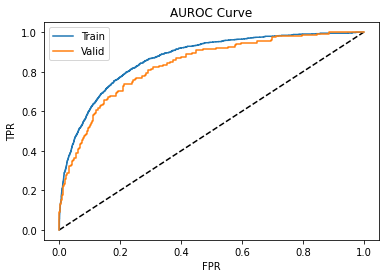

In [ ]:
pred_test = LR(train, valid, test, train_y, valid_y)

Train Accuracy: 0.9304; Validation Accuracy: 0.9353
Train AUROC: 0.8639
Valid AUROC: 0.6618



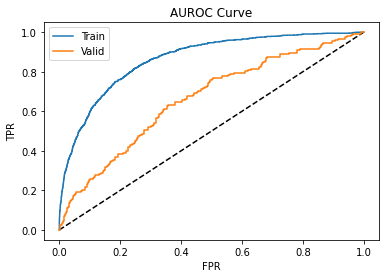

In [ ]:
pred_test = LR(pca_train, pca_valid, pca_test, train_y, valid_y)

Train Accuracy: 0.9304; Validation Accuracy: 0.9398
Train AUROC: 0.8639
Valid AUROC: 0.8312



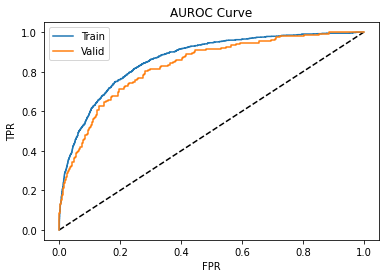

In [ ]:
pred_test = LR(svd_train, svd_valid, svd_test, train_y, valid_y)

Train Accuracy: 0.9269; Validation Accuracy: 0.9365
Train AUROC: 0.5217
Valid AUROC: 0.5000



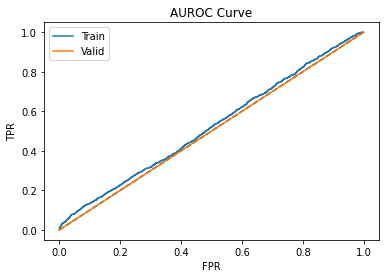

In [ ]:
#@title 有点离谱了叭
pred_test = LR(kpca_train, kpca_valid, kpca_test, train_y, valid_y)

Train Accuracy: 0.9269; Validation Accuracy: 0.9365
Train AUROC: 0.7288
Valid AUROC: 0.7280



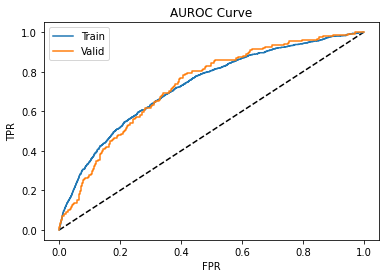

In [ ]:
pred_test = LR(ae_train, ae_valid, ae_test, train_y, valid_y)

Train Accuracy: 0.8345; Validation Accuracy: 0.7916
Train AUROC: 0.9081
Valid AUROC: 0.8506



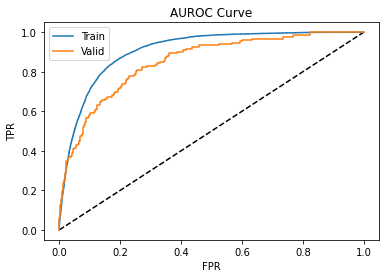

In [ ]:
from imblearn.over_sampling import SMOTE

train_resampled, train_y_resampled = SMOTE(random_state=seed).fit_resample(train, train_y)
pred_test = LR(train_resampled, valid, test, train_y_resampled, valid_y)

## LDA

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Train Accuracy: 0.9675; Validation Accuracy: 0.9273
Train AUROC: 0.9693
Valid AUROC: 0.8266



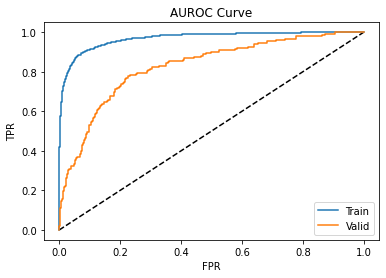

In [ ]:
lda = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto")
lda.fit(train, train_y)
pred_test = evaluate(lda, train, valid, test, train_y, valid_y, return_pred=True, version=1, return_auc=False, plot_auc=True)

# lda_train = lda.fit_transform(train, train_y)
# lda_valid = lda.transform(valid)
# lda_test = lda.transform(test)
# pred_test = lda.predict(valid)

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
def KNN(train, valid, test, train_y, valid_y, k=5):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train, train_y)
    return evaluate(knn, train, valid, test, train_y, valid_y, return_pred=True, plot_auc=True)

In [ ]:
# for i in range(3, 11, 2):
#     print(f"K = {i}")
#     pred = KNN(train, valid, test, train_y, valid_y, k=i)

Train Accuracy: 0.9352; Validation Accuracy: 0.9378
Train AUROC: 0.9877
Valid AUROC: 0.5487



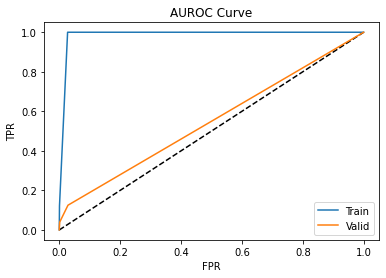

In [ ]:
pred_test = KNN(train, valid, test, train_y, valid_y, k=3)

Train Accuracy: 0.9269; Validation Accuracy: 0.9365
Train AUROC: 0.6810
Valid AUROC: 0.5217



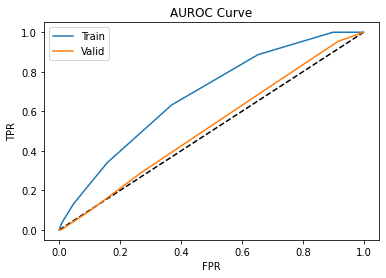

In [ ]:
pred_test = KNN(train, valid, test, train_y, valid_y, k=30)

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Train Accuracy: 1.0000; Validation Accuracy: 0.9415
Train AUROC: 1.0000
Valid AUROC: 0.8702



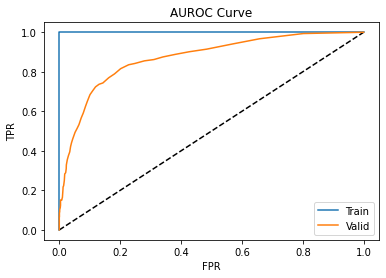

In [ ]:
rf = RandomForestClassifier(random_state=seed, criterion="gini")
rf.fit(train, train_y)
pred_test = evaluate(rf, train, valid, test, train_y, valid_y, return_pred=True, plot_auc=True)

Train Accuracy: 0.8659; Validation Accuracy: 0.8576
Train AUROC: 0.9076
Valid AUROC: 0.8665



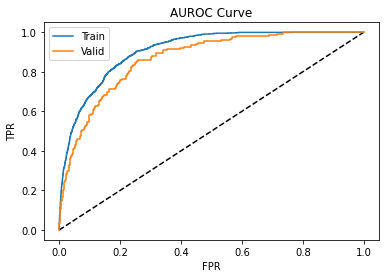

In [ ]:
rf = RandomForestClassifier(
    random_state=seed,
    criterion="gini",
    max_depth=None,
    max_features="sqrt",
    n_estimators=4000,
    min_samples_split=200,
    max_samples=4000,
    ccp_alpha=0, 
    class_weight="balanced_subsample"
)
rf.fit(train, train_y)
pred_test = evaluate(rf, train, valid, test, train_y, valid_y, return_pred=True, plot_auc=True)

## XGBOOST

In [ ]:
from xgboost import XGBClassifier
import xgboost

Train Accuracy: 0.9402; Validation Accuracy: 0.9474
Train AUROC: 0.9022
Valid AUROC: 0.8906



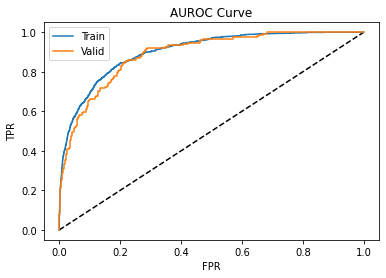

In [ ]:
try:
    train_ = train.to_numpy()[:, mi_importance_index]
    valid_ = valid.to_numpy()[:, mi_importance_index]
    test_ = test.to_numpy()[:, mi_importance_index]
except:
    train_ = train[:, mi_importance_index]
    valid_ = valid[:, mi_importance_index]
    test_ = test[:, mi_importance_index]
train_, valid_, test_ = std(train_, valid_, test_)

if num > 1000:
    colsample = max(0.4, 0.75 - (num // 100) * 0.01)
else:
    colsample = 0.8

xgb = XGBClassifier(
    random_state = seed,
    n_estimators = 200,
    # grow_policy = "lossguide",
    # scale_pos_weight = 1.5,
    max_depth = 3,
    # learning_rate = 0.1,
    eval_metric = ["auc"],
    # subsample = 0.8,
    colsample_bytree = 0.68,
    min_child_weight = 40,
    # reg_alpha = i,
    reg_lambda = 5,
    gamma = 10,
)

final_gb = xgb.fit(train_, train_y, eval_set=[(train_, train_y), (valid_, valid_y)], verbose=False, early_stopping_rounds=15)
pred_test = evaluate(xgb, train_, valid_, test_, train_y, valid_y, return_pred=True, version=1, plot_auc=True)
# xgb.save_model(f"./xgbmodels/task1-{num}-{xgb.best_ntree_limit}.json")

## XGBOOST Best

In [ ]:
from xgboost import XGBClassifier
import xgboost

In [ ]:
train = pd.read_pickle('./data/X_train.pkl')
valid = pd.read_pickle('./data/X_valid.pkl')
test = pd.read_pickle('./data/X_test.pkl')

In [ ]:
feature_num = train.shape[1]
mi_importance = np.load(f"./data/MI_importance_{feature_num}.npy")

num = 3000
mi_importance_index = np.argpartition(mi_importance, -num)[-num:]

Train Accuracy: 0.9449; Validation Accuracy: 0.9465
Train AUROC: 0.9395
Valid AUROC: 0.9093



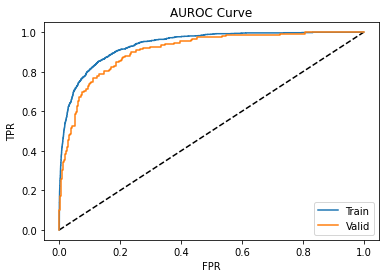

In [ ]:
try:
    train_ = train.to_numpy()[:, mi_importance_index]
    valid_ = valid.to_numpy()[:, mi_importance_index]
    test_ = test.to_numpy()[:, mi_importance_index]
except:
    train_ = train[:, mi_importance_index]
    valid_ = valid[:, mi_importance_index]
    test_ = test[:, mi_importance_index]
train_, valid_, test_ = std(train_, valid_, test_)

if num > 1000:
    colsample = max(0.4, 0.75 - (num // 100) * 0.01)
else:
    colsample = 0.8

xgb = XGBClassifier(
    random_state = seed,
    n_estimators = 200,
    # grow_policy = "lossguide",
    # scale_pos_weight = 1.5,
    max_depth = 3,
    # learning_rate = 0.1,
    eval_metric = ["auc"],
    subsample = 0.95,
    colsample_bytree = 0.65,
    min_child_weight = 30,
    # reg_alpha = i,
    reg_lambda = 8,
    gamma = 12,
)

final_gb = xgb.fit(train_, train_y, eval_set=[(train_, train_y), (valid_, valid_y)], verbose=False, early_stopping_rounds=15)
pred_test_1 = evaluate(xgb, train_, valid_, test_, train_y, valid_y, return_pred=True, version=1, plot_auc=True)
# xgb.save_model(f"./xgbmodels/task1-{num}-{xgb.best_ntree_limit}.json")

Train Accuracy: 0.9486; Validation Accuracy: 0.9457
Train AUROC: 0.9465
Valid AUROC: 0.9090



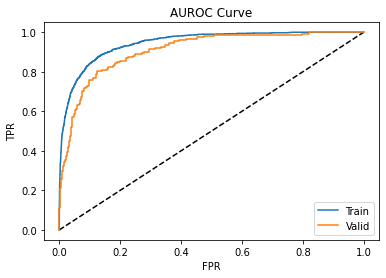

In [ ]:
try:
    train_ = train.to_numpy()[:, mi_importance_index]
    valid_ = valid.to_numpy()[:, mi_importance_index]
    test_ = test.to_numpy()[:, mi_importance_index]
except:
    train_ = train[:, mi_importance_index]
    valid_ = valid[:, mi_importance_index]
    test_ = test[:, mi_importance_index]
train_, valid_, test_ = std(train_, valid_, test_)

if num > 1000:
    colsample = max(0.4, 0.75 - (num // 100) * 0.01)
else:
    colsample = 0.8

xgb = XGBClassifier(
    random_state = seed,
    n_estimators = 200,
    # grow_policy = "lossguide",
    # scale_pos_weight = 1.5,
    max_depth = 3,
    # learning_rate = 0.1,
    eval_metric = ["auc"],
    # subsample = 0.8,
    colsample_bytree = 0.68,
    min_child_weight = 40,
    # reg_alpha = i,
    reg_lambda = 5,
    gamma = 10,
)

final_gb = xgb.fit(train_, train_y, eval_set=[(train_, train_y), (valid_, valid_y)], verbose=False, early_stopping_rounds=15)
pred_test = evaluate(xgb, train_, valid_, test_, train_y, valid_y, return_pred=True, version=1, plot_auc=True)
# xgb.save_model(f"./xgbmodels/task1-{num}-{xgb.best_ntree_limit}.json")

In [ ]:
allin = np.array(pd.read_csv("./allin.csv").iloc[:, 1])

# rf_train_y = xgb.predict_proba(train_)[:,1]
# rf_valid_y = xgb.predict_proba(valid_)[:,1]
# pred = xgb.predict_proba(test_)[:,1]

In [ ]:
# best1
prob = [0.65, 0.15, 0.2]
# best2
prob = [0.58, 0.22, 0.2]
prob = [0.7, 0.1, 0.2]
# bestn
prob = [0.45, 0.3, 0.25]
prob = [0.45, 0.4, 0.15]

pred_test_new = pred_test * prob[0] + pred_test_1 * prob[1] + allin * prob[2]

In [ ]:
# for i in np.arange(0, 1.1, 0.1):
#     print(f"{i:.1f}")
#     new_pred_train = i * allin + (1 - i) * rf_train_y
#     new_pred_valid = i * allin + (1 - i) * rf_valid_y
#     cm = confusion_matrix(train_y, rf_train_y)
#     tn, fp, fn, tp = cm.ravel()
#     print(f"Train AUROC: {roc_auc_score(train_y, rf_train_y):.4f}; FP: {fp:>4d}; FN: {fn:>4d}")
#     cm = confusion_matrix(valid_y, rf_valid_y)
#     tn, fp, fn, tp = cm.ravel()
#     print(f"Valid AUROC: {roc_auc_score(valid_y, rf_valid_y):.4f}; FP: {fp:>4d}; FN: {fn:>4d}")
#     print()

### Join Train + Valid

In [ ]:
train = pd.read_pickle('./data/X_train.pkl')
valid = pd.read_pickle('./data/X_valid.pkl')
test = pd.read_pickle('./data/X_test.pkl')

feature_num = 7488
mi_importance = np.load(f"./data/MI_importance_{feature_num}.npy")

num = 3000
mi_importance_index = np.argpartition(mi_importance, -num)[-num:]

In [ ]:
try:
    train = pd.concat([train, valid])
except:
    train = np.concatenate([train, valid], axis=0)

In [ ]:
try:
    train_y = pd.concat([train_y, valid_y])
except:
    train_y = np.concatenate([train_y, valid_y], axis=0)

In [ ]:
train.shape

(19154, 7488)

#### CV

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, random_state=seed, shuffle=True)
# imbalanced = 1
i = 1
pred_list = []
for train_index, valid_index in kf.split(train):
    print(f">>> CV = {i} <<<")
    i += 1
    # print("Train:", train_index, "Valid:", valid_index)
    try:
        kf_train, kf_valid = train.to_numpy()[train_index], train.to_numpy()[valid_index]
        std(kf_train, kf_train)
        kf_train_y, kf_valid_y = train_y.to_numpy()[train_index], train_y.to_numpy()[valid_index]
    except:
        kf_train, kf_valid = train[train_index], train[valid_index]
        std(kf_train, kf_train)
        kf_train_y, kf_valid_y = train_y.to_numpy()[train_index], train_y.to_numpy()[valid_index]
    
    try:
        train_ = kf_train.to_numpy()[:, mi_importance_index]
        valid_ = kf_valid.to_numpy()[:, mi_importance_index]
        test_ = test.to_numpy()[:, mi_importance_index]
    except:
        train_ = kf_train[:, mi_importance_index]
        valid_ = kf_valid[:, mi_importance_index]
        test_ = test.to_numpy()[:, mi_importance_index]
    train_, valid_, test_ = std(train_, valid_, test_)

    if num > 1000:
        colsample = max(0.4, 0.75 - (num // 100) * 0.01)
    else:
        colsample = 0.8

    xgb = XGBClassifier(
        random_state = seed,
        n_estimators = 200,
        # grow_policy = "lossguide",
        # scale_pos_weight = 1.5,
        max_depth = 3,
        # learning_rate = 0.1,
        eval_metric = ["auc"],
        subsample = 0.95,
        colsample_bytree = 0.65,
        min_child_weight = 30,
        # reg_alpha = i,
        reg_lambda = 8,
        gamma = 12,
    )

    final_gb = xgb.fit(train_, kf_train_y, eval_set=[(train_, kf_train_y), (valid_, kf_valid_y)], verbose=False, early_stopping_rounds=15)
    pred_test_1 = evaluate(xgb, train_, valid_, test_, kf_train_y, kf_valid_y, return_pred=True, version=1, plot_auc=False)
    pred_list.append(pred_test_1)

>>> CV = 1 <<<
Train Accuracy: 0.9494; Validation Accuracy: 0.9394
Train AUROC: 0.9442
Valid AUROC: 0.8949

>>> CV = 2 <<<
Train Accuracy: 0.9503; Validation Accuracy: 0.9371
Train AUROC: 0.9501
Valid AUROC: 0.9017

>>> CV = 3 <<<
Train Accuracy: 0.9467; Validation Accuracy: 0.9394
Train AUROC: 0.9428
Valid AUROC: 0.9053

>>> CV = 4 <<<
Train Accuracy: 0.9474; Validation Accuracy: 0.9389
Train AUROC: 0.9428
Valid AUROC: 0.9120

>>> CV = 5 <<<
Train Accuracy: 0.9471; Validation Accuracy: 0.9379
Train AUROC: 0.9422
Valid AUROC: 0.8992



In [ ]:
from functools import reduce

pred_test_new = pred_list[0] * 0.15 + pred_list[0] * 0.2 + pred_list[0] * 0.2 + pred_list[0] * 0.25 + pred_list[0] * 0.2
# pred_test_new = reduce(lambda x, y: x+y, pred_list) / 5

## Prediction

In [ ]:
id = pd.read_pickle("./stat3612-project-task1/test_id.pkl").values
with open('prediction.csv', 'w') as f:
    f.write('Id,Predicted\n')
    for i, y in enumerate(pred_test):
        f.write('{},{}\n'.format(id[i], y))

In [ ]:
id = pd.read_pickle("./stat3612-project-task1/test_id.pkl").values
with open('prediction.csv', 'w') as f:
    f.write('Id,Predicted\n')
    for i, y in enumerate(pred_test_new):
        f.write('{},{}\n'.format(id[i], y))